This Jupyter notebook is designed to help me learn about Quantum Variational Algorithms (QVA). Specifically, it focuses on the research presented in two articles: [“Variational Quantum Algorithms”](https://arxiv.org/abs/2012.09265) and [“Solving nonlinear differential equations with differentiable quantum circuits”](https://arxiv.org/abs/2011.10395). These papers propose new ways to design and optimize quantum circuits to solve problems in optimization theory and machine learning. With this notebook, I will explore the code used in these papers and gain a deeper understanding of the cutting-edge research being done in this exciting field.

Some examples of the notebook are take from [Qiskit Pocket Guide: Quantum Development with Qiskit](https://www.amazon.com/Qiskit-Pocket-Guide-Quantum-Development/dp/1098112474).

# Main idea:

There are challenges for developing quantum computers that are capable of performing *error-free operations*, also known as **fault-tolerant quantum computers**. These types of quantum computers (QC) are not expected to be available for several years due to the significant technical challenges involved in their development. In the meantime, a strategy known as **Variational Quantum Algorithms (VQAs)** has emerged as a leading approach for quantum computing under the current constraints. VQAs use a classical optimizer to train a parametrized quantum circuit, allowing for the creation of near-term quantum algorithms that can operate on the current generation of quantum hardware despite their limited resources and high error rates. This approach has shown promising results in fields such as optimization, machine learning, and quantum chemistry, and is an active topic of research in the quantum computing community.

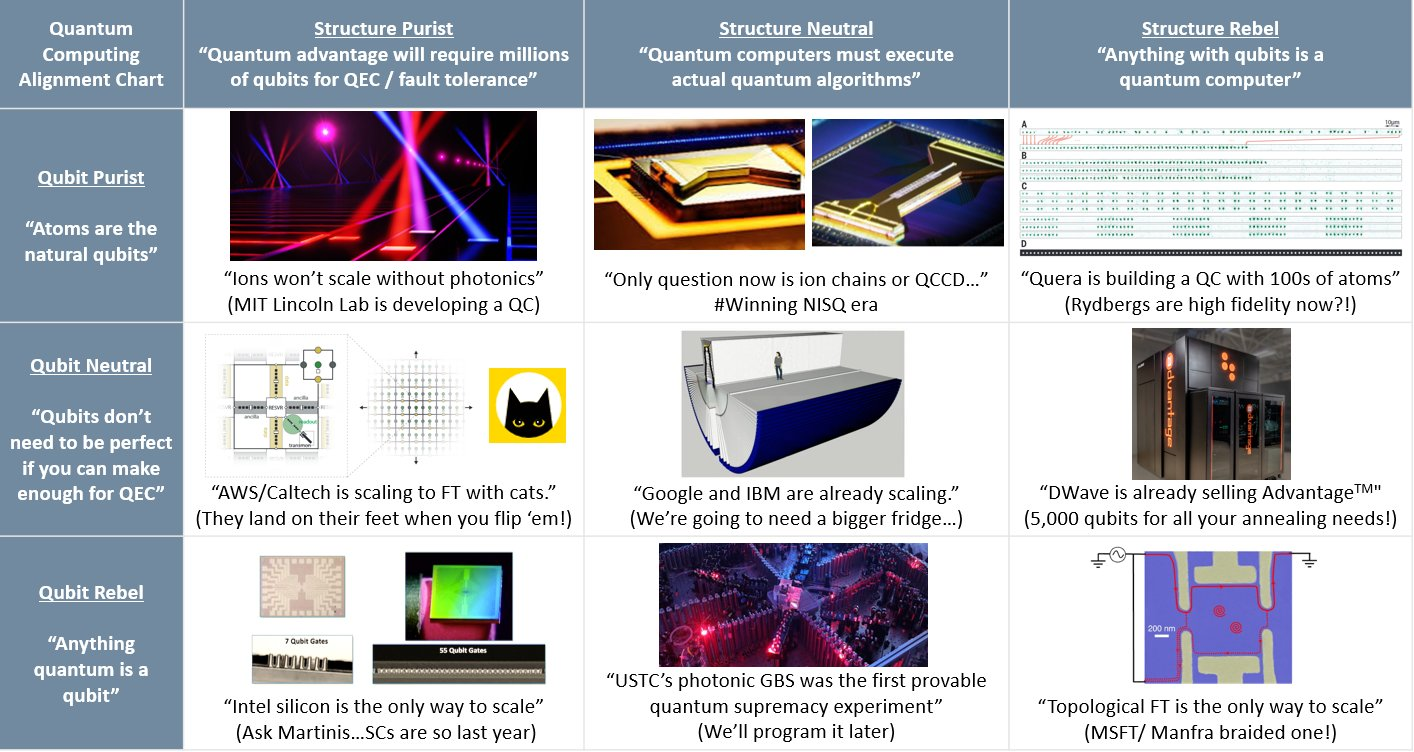 From [@BobNiffenegger](https://twitter.com/BobNiffenegger/status/1343642227755675649?s=20&t=ISzg_xJheiNze6fH4ymjxg)

## Introduction:

Classical simulation of quantum systems is a complex task that requires a significant amount of computational resources, which grow exponentially with the size of the system. Traditional quantum algorithms were designed assuming the availability of a large-scale fault-tolerant quantum computer, without taking into account factors like scaling prefactors, qubit requirements, and quantum circuit depth. However, the development of **Noisy Intermediate-Scale Quantum (NISQ)** computers generated excitement around the potential practical applications of quantum computing, and Variational Quantum Algorithms (VQAs) emerged as a natural strategy to address the constraints of current quantum hardware. VQAs use parametrized quantum circuits that are optimized by a classical optimizer. However, VQAs still face challenges in terms of efficiency, accuracy, and trainability.

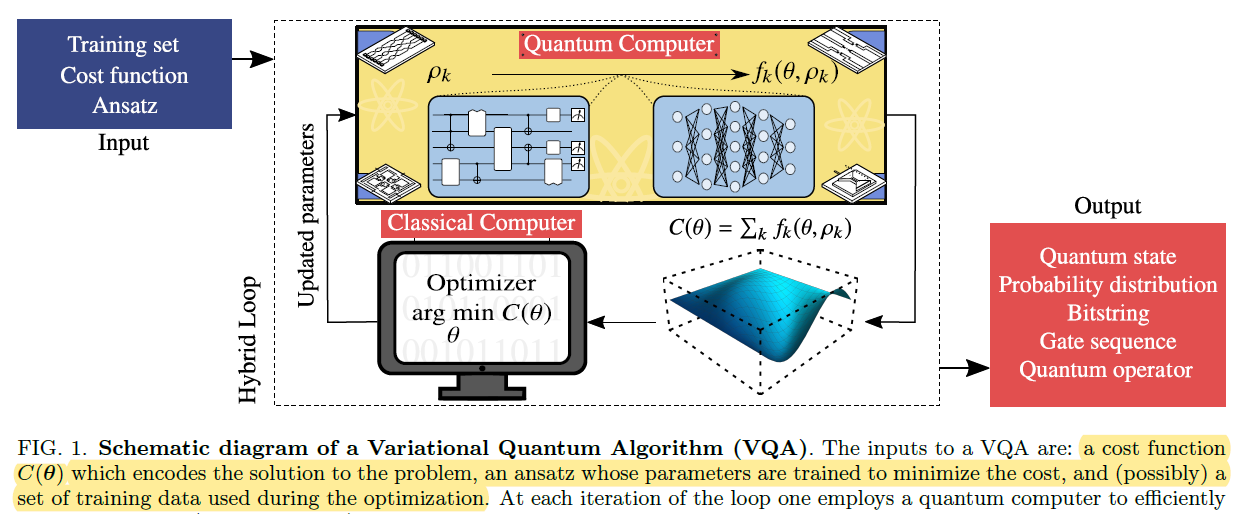

### Commercial break: Shor’s quantum algorithm

**Shor's quantum algorithm** is a method for factoring large numbers using a quantum computer. It was proposed by mathematician Peter Shor in the mid-1990s and utilizes the abilities of a quantum computer to efficiently perform certain types of mathematical operations. The algorithm has exponential speedup over classical methods and was initially designed with the assumption that a large-scale fault-tolerant quantum computer would someday be available.

In [1]:
# Choose a backend to use:
from qiskit.providers.aer import AerSimulator
aer_sim = AerSimulator() #Represents a simulator backend for Qiskit, meaning it is used to simulate the behavior of a QC.

In [2]:
# Create an instance of Shor's algorithm, using our backend:
from qiskit.algorithms import Shor
shor = Shor(aer_sim)

C:\Users\dafda\AppData\Local\Temp\ipykernel_4948\2076042679.py:3: DeprecationWarning: The Shor class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-algorithms/shor.html
        
  shor = Shor(aer_sim)


In [3]:
# We execute Shor's algorithm to factorize the number 15 and view the result:

result = shor.factor(15)
result.factors

[[3, 5]]

### Commercial break stop.

## Basic concepts and tools

VQAs have common features that they share:

- A cost or loss function called C is used to encode the solution to a problem.
- An ansatz is proposed using quantum operation with a set of parameters that can be optimized.

### (1) Cost function:

**Big idea:** It is hyper-surface usually called the *cost landscape* such that the task of the optimizer is to navigate through the landscape and find the global minima.

**In other words:** The cost function plays different roles in different applications. For example, it can be the value to minimize including constraints in an optimization problem. It can be the energy of a molecule in quantum chemistry. This cost function can be mapped onto a quantum circuit with adjustable parameters in VQA.

$C(\theta)=\sum_{k} f_{k}(Tr[O_{k}U(\theta)\rho_{k}U^{dagger}(\theta)])$

- The cost function assigns real number values to the adjustable parameters' $\theta$.

- The cost function must satisfy certain criteria, including being faithful to the solution of the problem, efficiently estimable using QC measurements with classical post-processing, meaningful in terms of the solution quality it indicates, and trainable by efficiently optimizing parameters $\theta$.

- Estimating C($\theta$) should maintain small circuit depth and the requirements due to the limitations of NISQ devices, such as gate errors and limited qubit counts with short decoherence times.

In [4]:
# Example: how to run the Variational Quantum Eigensolver (VQE) algorithm to find the minimum eigenvalue of an operator.

from qiskit.algorithms import VQE # Import VQE class
from qiskit.circuit.library import EfficientSU2 # Import EfficientSU2 circuit.

We will create for this example a linear combination of *Pauli operators*. This operator is the Hamiltonian that we want to compute the minimum eigenvalue of.

In [5]:
from qiskit.opflow import X, Y, Z, I
op = ( .10 * (X ^ Y ^ Z) + .4 * (Y ^ Y ^ I) - .6 * (Z ^ X ^ Z) + .4 * (I ^ X ^ Y))

In [6]:
circuit = EfficientSU2() # This we will see if after, right now, is what we call the "ansatz”.

vqe = VQE(circuit, quantum_instance=AerSimulator(method='statevector')) # The AerSimulator backend is used to run the circuit.

result = vqe.compute_minimum_eigenvalue(op) # The lowest eigenvalue of the Hamiltonian,
result.eigenvalue.real # The minimum eigenvalue.

-1.0914203514256942

In [7]:
result.cost_function_evals # The number of function evaluation or the times the algorithm measured the expectation value.

553

Or in other words: `result.cost_function_evals` refers to the number of times the cost function was evaluated during the execution of the VQE algorithm.

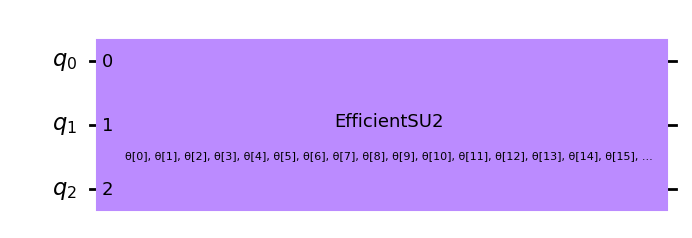

In [8]:
circuit.draw(output='mpl')

It consists of layers of single-qubit operations and entangling gates, specifically rotations in SU(2) and CX gates (*controlled-NOT gate*). SU(2) stands for special unitary Lie algebra, its elements are $2 \times 2$ unitary matrices with determinant 1, such as the Pauli rotation gates.

On 3 qubits and using the Pauli $Y$ and $Z$ as single qubit gates, the hardware efficient SU(2) circuit is represented by:

        ┌──────────┐┌──────────┐ ░            ░       ░ ┌───────────┐┌───────────┐
        ┤ RY(θ[0]) ├┤ RZ(θ[3]) ├─░────────■───░─ ... ─░─┤ RY(θ[12]) ├┤ RZ(θ[15]) ├
        ├──────────┤├──────────┤ ░      ┌─┴─┐ ░       ░ ├───────────┤├───────────┤
        ┤ RY(θ[1]) ├┤ RZ(θ[4]) ├─░───■──┤ X ├─░─ ... ─░─┤ RY(θ[13]) ├┤ RZ(θ[16]) ├
        ├──────────┤├──────────┤ ░ ┌─┴─┐└───┘ ░       ░ ├───────────┤├───────────┤
        ┤ RY(θ[2]) ├┤ RZ(θ[5]) ├─░─┤ X ├──────░─ ... ─░─┤ RY(θ[14]) ├┤ RZ(θ[17]) ├
        └──────────┘└──────────┘ ░ └───┘      ░       ░ └───────────┘└───────────┘

### Commercial break: The cost function in classical computation

Suppose we have a dataset consisting of pairs of input-output data $(x^{(i)},y^{(i)})$ where each $x^{(i)}$ is a scalar and each $y^{(i)}$ is a scalar output. We want to learn a linear function $f(x)=w_1 x + w_0$ that maps inputs to outputs using the following cost function:

$$J(w_0,w_1) = \frac{1}{2n} \sum_{i=1}^n (f(x^{(i)}) - y^{(i)})^2$$

where $n$ is the number of training examples. The goal is to choose $w_0$ and $w_1$ such that $J(w_0,w_1)$ is minimized.

We could define a function that takes the weights $w_0$ and $w_1$, the inputs $x$, and the outputs $y$, and returns the value of $J(w_0,w_1)$.

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Generate some fake data for a line with slope 2 and intercept 1
x = np.linspace(0, 1, 100)
y = 2 * x + 1 + np.random.randn(100)*0.1

In [11]:
# Define the cost function
def cost_function(w0, w1, x, y):
    # Number of training examples
    n = len(x)
    
    # Compute sum of squared errors
    sse = sum((w1 * x[i] + w0 - y[i])**2 for i in range(n))
    
    # Compute cost function value
    J = sse / (2 * n)
    
    return J

In [12]:
# Initialize weights at random
w0 = np.random.randn()
w1 = np.random.randn()

In [13]:
# Set learning rate and number of iterations
alpha = 0.1
niter = 1000

In [14]:
# Gradient descent loop
for i in range(niter):
    # Compute gradient of cost function
    grad_w0 = sum(w1 * x[i] + w0 - y[i] for i in range(len(x))) / len(x)
    grad_w1 = sum((w1 * x[i] + w0 - y[i]) * x[i] for i in range(len(x))) / len(x)
    
    # Update weights using gradient descent
    w0 -= alpha * grad_w0
    w1 -= alpha * grad_w1
    
    # Compute cost function value at new weights
    J = cost_function(w0, w1, x, y)
    print("Iteration %d: J = %f, w0 = %f, w1 = %f" % (i, J, w0, w1))

Iteration 0: J = 1.138649, w0 = 0.012972, w1 = 1.021352
Iteration 1: J = 0.870495, w0 = 0.160864, w1 = 1.103559
Iteration 2: J = 0.666018, w0 = 0.289856, w1 = 1.175618
Iteration 3: J = 0.510092, w0 = 0.402346, w1 = 1.238813
Iteration 4: J = 0.391186, w0 = 0.500427, w1 = 1.294266
Iteration 5: J = 0.300508, w0 = 0.585928, w1 = 1.342958
Iteration 6: J = 0.231354, w0 = 0.660444, w1 = 1.385743
Iteration 7: J = 0.178610, w0 = 0.725369, w1 = 1.423369
Iteration 8: J = 0.138380, w0 = 0.781920, w1 = 1.456488
Iteration 9: J = 0.107692, w0 = 0.831160, w1 = 1.485670
Iteration 10: J = 0.084279, w0 = 0.874017, w1 = 1.511413
Iteration 11: J = 0.066413, w0 = 0.911301, w1 = 1.534150
Iteration 12: J = 0.052778, w0 = 0.943720, w1 = 1.554261
Iteration 13: J = 0.042368, w0 = 0.971891, w1 = 1.572078
Iteration 14: J = 0.034418, w0 = 0.996355, w1 = 1.587889
Iteration 15: J = 0.028344, w0 = 1.017581, w1 = 1.601948
Iteration 16: J = 0.023700, w0 = 1.035982, w1 = 1.614474
Iteration 17: J = 0.020146, w0 = 1.051917

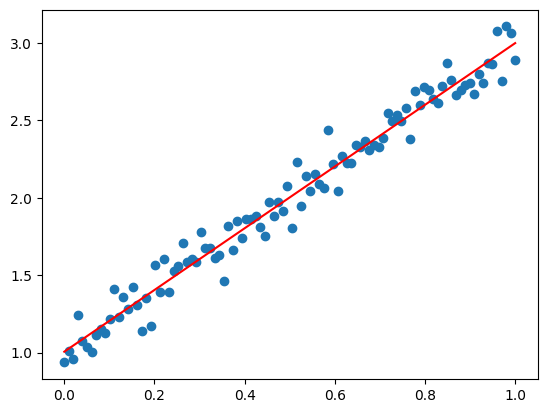

In [15]:
# Plot data points and learned function
plt.scatter(x, y)
plt.plot(x, w1 * x + w0, color='red')
plt.show()

The cost function takes in the predictions made by the model and compares them to the actual values of the target variable. The result of this comparison is a measure of the error or *“cost”* of the model. By minimizing this cost function using optimization algorithms like gradient descent, we can adjust the parameters of the model to make better predictions and improve the model's performance.

In quantum optimization, the cost function maps the problem variables to a real number, which represents the "cost" or "energy" associated with that particular set of variable values. The goal is to minimize this cost function in order to find the optimal values of the variables that solve the optimization problem.

### Commercial break stop.

### (2) Ansatze:

In general, the parameters for cost minimization are determined by the form of the ansatz used. Some **ansatz** architectures are specific to certain problems, while others are generic and can be applied to problems without any relevant information. In our previous example with VQE, the `EfficientSU2()` was the ansatz.

According to the first article, they are various types:

- Hardware efficient ansatz.
- Unitary coupled clustered ansatz.
- Quantum alternating operator ansatz (QAOQ): The most famous VQA for quantum-enhanced optimization is the QAOA, originally introduced to approximately solve combinatorial problems such as Constraint Satisfaction (SAT) and Max-Cut problems.
- Variational Hamiltonian ansatz: Inspired by the QAOA, the variational Hamiltonian ansatz also aims to prepare a trial ground states for a given Hamiltonian H = k Hk by Trotterizing an adiabatic state preparation process.
- ADAPT-VQE.
- Sub-logical ansatz and quantum optimal control.
- Hybrid anstze.
- Ansatz for mixed states.
- Ansatz expressibility.

### (3) Gradients:

The next step is to train the parameters $\theta$ and solve the optimization problem. Leveraging information from the cost function gradient or higher-order derivatives can improve the speed and guarantee the convergence of the optimizer. Some gradients mention by the article are:

- Parameter shift-rule: This one is actually mention also in [“Solving nonlinear differential equations with differentiable quantum circuits”](https://arxiv.org/abs/2011.10395). 
- Other derivatives.

### Commercial break: Gradient descent for dummies.

Imagine you have a problem where you want to find the lowest point of a curve. You start with a guess at the lowest point, and then ask a computer to help you find the real lowest point. The computer calculates the slope of the curve at your guess point, and then adjusts your guess slightly downhill in the direction of the slope. Then, it checks the new point to see if it's at a lower elevation. If it is, it moves downhill again by adjusting the guess in the direction of the new slope, and if it's not, it moves your guess slightly uphill and tries again. It keeps doing this repeatedly, making smaller and smaller adjustments as it gets closer and closer to the bottom of the curve, until it finds the lowest point it can.

That's basically what gradient descent does—it helps you find the minimum value of a mathematical function by iteratively adjusting the input values until you get the output value that is as low as possible.

*A more serious explanation:*

- First, we start with a set of parameters (also known as coefficients or weights) that define our function.

- We then evaluate our function with these parameters, which gives us a cost, or error, that we want to minimize.

- Next, we calculate the gradient of our function, which is a vector that points in the direction of steepest ascent.

- We then move our parameters in the opposite direction of the gradient, which reduces the cost of our function.

- We repeat this process, adjusting our parameters each time we evaluate the function, until we reach a minimum.

In essence, gradient descent is a way to iteratively adjust parameters in a function to get closer and closer to the “optimal” set of parameters that minimizes the error.

### Commercial break stop.

In [16]:
class VQELog():
    def __init__(self):
        self.counts = []
        self.params = []
        self.means = []
    def callback(self, eval_count, params, mean, std_dev):
        self.counts.append(eval_count) # The number of steps taken so far in the optimization.
        self.params.append(params) # The parameters of the parameterized circuit at this point in the optimization.
        self.means.append(mean) # This is the estimated expectation value at this point in the optimization.

In [17]:
from qiskit.algorithms.optimizers import (GradientDescent)

log = VQELog()

vqe = VQE(EfficientSU2(), optimizer=GradientDescent(learning_rate=0.2), callback=log.callback, quantum_instance=AerSimulator(method='statevector'))

result = vqe.compute_minimum_eigenvalue(op)
result.eigenvalue.real

-1.0903569388612533

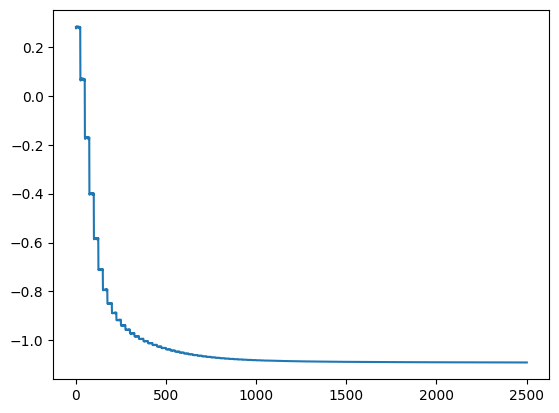

In [18]:
import matplotlib.pyplot as plt
plt.plot(log.counts, log.means);

### (4) Optimizers:

When developing a VQA, it is possible to face new challenges, such as the stochastic nature of the environment caused by a limited budget for measurements, hardware noise, and barren plateaus. This has lead to the development of many quantum-aware optimizers. Some of the ones mention in the article are:

- Gradient descend method.
- Simultaneous perturbation stochastic approximation (SPSA) method.
- Convergence analysis.

In [19]:
from qiskit.algorithms.optimizers import COBYLA # Constrained Optimization By Linear Approximation.

log = VQELog()

vqe = VQE(EfficientSU2(), optimizer=COBYLA(), callback=log.callback, quantum_instance=AerSimulator(method='statevector'))

result = vqe.compute_minimum_eigenvalue(op)
result.eigenvalue.real

-1.0914203086129497

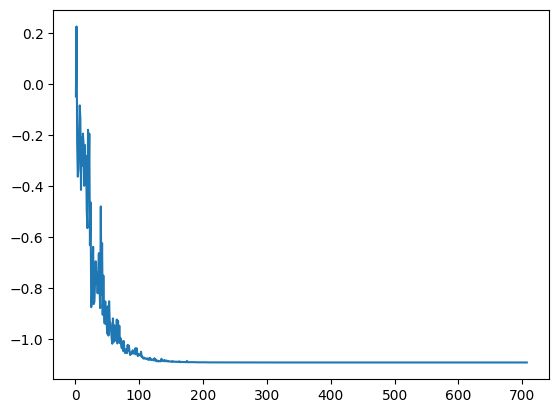

In [20]:
import matplotlib.pyplot as plt
plt.plot(log.counts, log.means);

## Applications

- **Finding ground and excited states**: The most typical usage of VQAs is to estimate the low-energy states and their associated values of a given Hamiltonian.

Among algorithms that does that:

- VQE (we saw it above).
- Orthogonality constrained VQE.
- Subspace expansion method.
- Subspace VQE.
- Multistate contracted VQE. 
- Adiabatically assisted VQE. 
- Accelerated VQE.

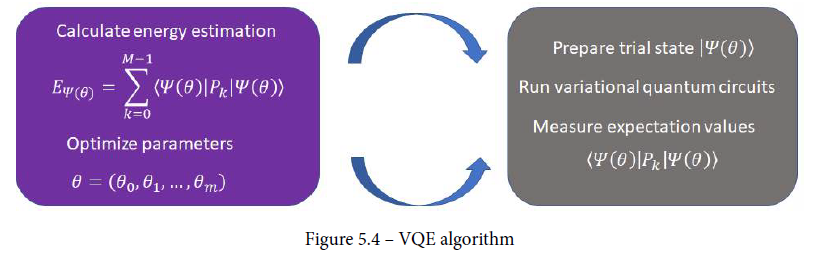

In NISQ devices, circuit depth increases with system size and simulated time, often resulting in hardware errors that are prohibitive due to noise. VQAs can also be applied to simulate the dynamical evolution of a quantum system:

- Iterative approach.
- Subspace approach.
- Variational fast forwarding.
- Simulating open systems.

Some other mathematical applications: linear systems, partial differential equations, principal component analysis, etc.

### Examples:

To see more examples related to the use of VQE in chemistry: https://learn.qiskit.org/course/ch-applications/simulating-molecules-using-vqe

## Challenges and potential solutions:

Although there have been significant advancements in VQAs, there remain numerous challenges to achieving quantum speedup when scaling up NISQ architectures. It is important to fully comprehend the limitations of VQAs to develop superior algorithms, guarantee their performance, and advance quantum hardware.

- **The Barren Plateau (BP)** phenomenon: is a bottleneck for VQAs due to the partial derivatives of the cost function exponentially vanishing with the system size. This results in the exponential scaling in precision, which eliminates the possibility of quantum advantage using VQAs, as the computational complexity will be equivalent to classical algorithms. However, it was shown that the BP phenomenon is cost-function dependent, with global cost functions showing BPs, while local cost functions exhibit gradients vanishing polynomially in n with logarithmic circuit depth. This implies a connection between locality and trainability and provides insight into the types of cost functions that should be avoided in VQAs. It has two potential strategies, parameter initialization and ansatz strategies. In the case of the first one, The concept behind this method is to decrease circuit randomness and depth to prevent the assumption that the circuit approaches a 2-design, which is necessary for Barren Plateaus to occur in deep ansatze.

- **Efficiency**: Efficient estimation of expectation values is necessary for VQAs to provide a quantum advantage with more general cost functions. It may be impractical to take projective measurements onto the eigenbasis of the relevant operator due to the high computational complexity of finding the necessary unitary, as well as the depth required to implement the transformation. However, since arbitrary Pauli operators can be diagonalized with one layer of single qubit rotations, it is typical for relevant operators to be expressed by their decomposition into Pauli operators, such as those found in quantum chemistry Hamiltonians. Solutions include: optimized sampling, classical shadow, etc.

- **Accuracy**: The primary objective of VQAs is to offer a practical application for near-term noisy devices. VQAs can reduce quantum circuit depth, which may minimize the impact of hardware noise. However, the accuracy of VQAs may still be affected by hardware noise. Some solutions include: the effect of noise could help the training process. In this case, the presence of incoherent noise flattens the cost landscape, reducing the magnitudes of gradients. This is due to the reduction of gradient magnitudes caused by the flattening of the cost landscape from the presence of incoherent noise. Other solutions include classical post-processing, symmetry verification, etc.

### Commercial break: Optimization issues.

The paper talks about some quantum advantages that are in chemistry, nuclear physics, and particle physics. It also mentions the next optimization issues:

- The Max-Cut problem is a type of optimization problem in graph theory, where the goal is to divide the vertices of an undirected graph into two partitions such that the number of edges between the partitions is maximized. It is known to be NP-hard, meaning that no known efficient algorithm currently exists to solve it for all instances.

- The Max-Cut problem is closely related to the Max-Cut Approximation problem, where the goal is to find an approximate solution to the Max-Cut problem that is within a certain factor of the optimal solution. This issue is also known to be NP-hard.

Overall, the Max-Cut and Max-Cut Approximation problems are important problems in the fields of computer science, optimization theory, and graph theory with many real-world applications, such as in network design and community detection.

The article mentions that QAOA is widely considered to be one of the leading candidates for achieving quantum advantage  this optimization issue.

### Commercial break stop.

## Final conclusions for the future:

The future of VQAs (Variational Quantum Algorithms) lies in analytical and heuristic scaling analysis for quantum advantage. Improving gradient scaling and optimizing cost landscape via better-toolbox VQAs will mitigate small gradients and runtime training of parameters. Error mitigation strategies incorporated on cloud-based quantum computing platforms will help in achieving accurate results. Furthermore, better quantum hardware and state-of-the-art VQAs designed for larger, more realistic problems will be developed, pushing the limits of NISQ devices, and aiming to reach quantum advantage.

Overall, the future of VQAs appears bright, with much research and development still to be done and significant potential for real-world applications! A very nice example of that is the second reference: [“Solving nonlinear differential equations with differentiable quantum circuits”](https://arxiv.org/abs/2011.10395)